# Project Pipeline - step \#0: Colab Environment setup

## Imports

In [ ]:
import random as rnd
import pandas as pd
import numpy as np
import numpy.linalg as la
import string
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import A_data_collection as data_collection
import D_data_analysis as data_analysis
import E_plot_results as plot_results

In [ ]:
!pip install recordlinkage
import recordlinkage

  Using cached recordlinkage-0.16-py3-none-any.whl (926 kB)
  Using cached jellyfish-1.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)


In [ ]:
seed = 42

##Project-specific constants

In [ ]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]
SEED = 2023
NUM_EXPERIMENTS = 10

np.random.seed(SEED)
rnd.seed(SEED)

# Project Pipeline - step \#1: Data Collection

In [ ]:
INIT_FEATURES = 5
NUM_INFORMATIVE = 5
NUM_REDUNDANT = INIT_FEATURES - NUM_INFORMATIVE
assert NUM_REDUNDANT >= 0

In [ ]:
# dataset for duplication experiments
X_dup, y_dup = data_collection.make_dataset_for_classification(n_samples=1000, n_features=INIT_FEATURES, n_informative=NUM_INFORMATIVE, n_redundant=NUM_REDUNDANT, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

In [ ]:
# dataset for variable types experiments
X_var, y_var = data_collection.make_dataset_for_classification(n_samples=1000, n_features=INIT_FEATURES, n_informative=NUM_INFORMATIVE, n_redundant=NUM_REDUNDANT, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

In [ ]:
# dataset for usage example
example_dataset, example_labels = data_collection.make_dataset_for_classification(n_samples=5, n_features=INIT_FEATURES, n_informative=NUM_INFORMATIVE, n_redundant=NUM_REDUNDANT, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

# Project Pipeline - step \#2: Data Pollution

## Duplication issue
The following pollution functions are used to inject non-exact duplicates into the dataset, for a total of 10 different experiments.

### Pollution Functions

#### Rounding-off pollution function
This pollution function randomly picks a percentage of entries from the dataset, duplicates them, and shaves off a random amount of digits, to a random digit, for a random amount of features.

In [ ]:
def pollute_round_off(dataset, labels, percentage):

  '''
  Create duplicates from the dataset of size (percentage * dataset.shape[0]) and
   apply rounding off to a random number of features with random digits.

  Parameters:
    dataset (numpy.ndarray): The dataset to be duplicated and polluted.
    labels (numpy.ndarray): The labels of the dataset.
    percentage (float): The fraction of the dataset size to duplicate.

  Returns:
    numpy.ndarray: The polluted dataset with duplicates.

  Raises:
    ValueError: If the dataset is empty or if the percentage is not between 0 and 1.
  '''

  if not (0 < percentage < 1):
    raise ValueError("Percentage must be between 0 and 1.")

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    raise ValueError("Dataset must be non-empty.")

  num_duplicates = int(num_entries * percentage)

  if num_duplicates == 0:
    num_duplicates = 1

  # Select random entries to duplicate and create a deep copy
  duplicate_indices = rnd.sample(range(num_entries), num_duplicates)
  duplicate_data = dataset[duplicate_indices].copy()
  duplicate_labels = labels[duplicate_indices].copy()

  for entry in duplicate_data:
    num_round_features = rnd.randint(1, num_features)

    round_features = rnd.sample(range(num_features), num_round_features)

    for feature in round_features:
      # Calculate the digits of a data point
      entry_digits = len(str(entry[feature]).split('.')[1]) - 1 # Remove digit before comma

      # Randomly select how many digits to round off
      digits = rnd.randint(1, entry_digits - 1) # Remove 1 to avoid chance of exact duplicates (Extremes are included in randint)
      entry[feature] = np.round(entry[feature], digits) # Round entry to generated digit

  return (np.append(dataset, duplicate_data, axis=0), np.append(labels, duplicate_labels, axis=0))

**Usage example**

In [ ]:
percentage = .5

polluted_dataset, polluted_labels = pollute_round_off(example_dataset, example_labels, percentage)

In [ ]:
example_dataset, example_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]]),
 array([1, 0, 1, 0, 0]))

In [ ]:
polluted_dataset, polluted_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.49      ],
        [-0.8982    ,  1.4       , -0.79674393,  0.1716    ,  0.02322873]]),
 array([1, 0, 1, 0, 0, 1, 0]))

#### Gaussian Noise pollution function
This pollution function randomly picks a percentage of entries from the dataset, duplicates them, and applies a Gaussian noise to them.

In [ ]:
def pollute_gaussian_noise(dataset, labels, percentage, mean=0):

  '''
  Create duplicates from the dataset of size (percentage * dataset.shape[0]) and
   add Gaussian noise of mean MEAN and variance proportional to the dataset's
   variance, to each feature of each duplicate.

  Parameters:
    dataset (numpy.ndarray): The dataset to be duplicated and polluted.
    labels (numpy.ndarray): The labels of the dataset.
    percentage (float): The fraction of the dataset size to duplicate.
    mean (float): The mean of the Gaussian noise distribution.

  Returns:
    numpy.ndarray: The polluted dataset with duplicates.

  Raises:
    ValueError: If the dataset is empty or if the percentage is not between 0 and 1.
  '''

  if not (0 < percentage < 1):
    raise ValueError("Percentage must be between 0 and 1.")

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    raise ValueError("Dataset must be non-empty.")

  num_duplicates = int(num_entries * percentage)

  if num_duplicates == 0:
    num_duplicates = 1

  # Calculate the standard deviation of the dataset
  std_dev_data = np.std(dataset)

  # Determine a scaling factor for the noise
  scaling_factor = 0.1  # 10% of the data's standard deviation

  # Calculate the standard deviation for the noise
  std_dev_noise = scaling_factor * std_dev_data

  # Select random entries to duplicate and create a deep copy
  duplicate_indices = np.random.choice(num_entries, size=num_duplicates)
  duplicate_data = dataset[duplicate_indices].copy()
  duplicate_labels = labels[duplicate_indices].copy()

  for entry in duplicate_data:
    noise = np.random.normal(mean, std_dev_noise, num_features)
    entry += noise

  return (np.append(dataset, duplicate_data, axis=0), np.append(labels, duplicate_labels, axis=0))

**Usage example**

In [ ]:
percentage = .5

polluted_dataset, polluted_labels = pollute_gaussian_noise(example_dataset, example_labels, percentage)

In [ ]:
example_dataset, example_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]]),
 array([1, 0, 1, 0, 0]))

In [ ]:
polluted_dataset, polluted_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [ 0.88981186,  2.150672  , -3.46835508, -0.70980104, -1.64897999],
        [-1.0437219 ,  1.25501095, -0.86133709,  0.09596303,  0.04895464]]),
 array([1, 0, 1, 0, 0, 0, 0]))

####Scaling pollution function
This pollution function randomly picks a percentage of entries from the dataset, duplicates them, and scales them to a different, randomly chosen unit of measurement.

In [ ]:
def pollute_scaling(dataset, labels, percentage, min_exp=-12, max_exp=12):

  '''
  Create duplicates from the dataset of size (percentage * dataset.shape[0]) and
   scales them to a different, randomly chosen unit of measurement (i.e.,
   multiplies each data item for a factor that is 10^exp, where exp is a random
   exponent between MIN_EXP and MAX_EXP.

  Parameters:
    dataset (numpy.ndarray): The dataset to be duplicated and polluted.
    labels (numpy.ndarray): The labels of the dataset.
    percentage (float): The fraction of the dataset size to duplicate.
    min_exp (int): The lower bound of powers of 10 for scaling pollution.
    max_exp (int): The upper bound of powers of 10 for scaling pollution.

  Returns:
    numpy.ndarray: The polluted dataset with duplicates.

  Raises:
    ValueError: If the dataset is empty or if the percentage is not between 0 and 1.
  '''

  if not (0 < percentage < 1):
    raise ValueError("Percentage must be between 0 and 1.")

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    raise ValueError("Dataset must be non-empty.")
  num_duplicates = int(num_entries * percentage)

  if num_duplicates == 0:
    num_duplicates = 1

  # Select random entries to duplicate and create a deep copy
  duplicate_indices = np.random.choice(num_entries, size=num_duplicates)
  duplicate_data = dataset[duplicate_indices].copy()
  duplicate_labels = labels[duplicate_indices].copy()

  for entry in duplicate_data:
      # pollute the elements of the row with the same scale
      exp = rnd.randint(min_exp, max_exp)
      entry *= (10 ** exp)

  return (np.append(dataset, duplicate_data, axis=0), np.append(labels, duplicate_labels, axis=0))

**Usage example**

In [ ]:
percentage = .5

polluted_dataset, polluted_labels = pollute_scaling(example_dataset, example_labels, percentage)

In [ ]:
example_dataset, example_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]]),
 array([1, 0, 1, 0, 0]))

In [ ]:
polluted_dataset, polluted_labels

(array([[-9.49209246e-01,  3.35684837e-01, -1.41548407e+00,
         -1.78576295e+00, -4.87586737e-01],
        [-3.35471844e+00, -1.48958790e+00,  4.78912548e-01,
         -2.63812044e+00,  2.55899262e-01],
        [ 2.84290930e+00,  8.36331225e-01, -1.89775432e+00,
          1.68994257e+00, -5.92244007e-01],
        [ 8.04603049e-01,  2.24711467e+00, -3.28064942e+00,
         -1.04541570e+00, -1.63415213e+00],
        [-8.98167260e-01,  1.39373349e+00, -7.96743925e-01,
          1.71593173e-01,  2.32287279e-02],
        [ 8.04603049e+04,  2.24711467e+05, -3.28064942e+05,
         -1.04541570e+05, -1.63415213e+05],
        [-3.35471844e-06, -1.48958790e-06,  4.78912548e-07,
         -2.63812044e-06,  2.55899262e-07]]),
 array([1, 0, 1, 0, 0, 0, 0]))

####Swapping pollution function
This pollution function randomly picks a percentage of entries from the dataset, duplicates them, and swaps a random amount of features.

In [ ]:
def pollute_swapping(dataset, labels, percentage):

  '''
  Create duplicates from the dataset of size (percentage * dataset.shape[0]) and
   swaps a randomly chosen number of features.

  Parameters:
    dataset (numpy.ndarray): The dataset to be duplicated and polluted.
    labels (numpy.ndarray): The labels of the dataset.
    percentage (float): The fraction of the dataset size to duplicate.

  Returns:
    numpy.ndarray: The polluted dataset with duplicates.

  Raises:
    ValueError: If the dataset is empty, if the dataset has just one feature,
    or if the percentage is not between 0 and 1.
  '''

  if not (0 < percentage < 1):
    raise ValueError("Percentage must be between 0 and 1.")

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    raise ValueError("Dataset must be non-empty.")

  if num_features <= 1:
    raise ValueError("Dataset must have at least two features.")

  num_duplicates = int(num_entries * percentage)

  if num_duplicates == 0:
    num_duplicates = 1

  # Select random entries to duplicate and create a deep copy
  duplicate_indices = np.random.choice(num_entries, size=num_duplicates)
  duplicate_data = dataset[duplicate_indices].copy()
  duplicate_labels = labels[duplicate_indices].copy()

  for entry in duplicate_data:

    # randomly choose how many times to swap
    num_swap_features = rnd.randint(1, num_features - 1)

    # randomly choose the new order of features
    new_features_order = list(range(num_features))

    old_entry = entry.copy()
    while np.array_equal(old_entry, entry):
      for _ in range(num_swap_features):
        index1 = 0
        index2 = 0
        while index1 == index2:
          index1, index2 = np.random.choice(num_features, size=2)
        new_features_order[index1], new_features_order[index2] = new_features_order[index2], new_features_order[index1]
        # apply the new order of features
        entry[:] = entry[new_features_order]

  return (np.append(dataset, duplicate_data, axis=0), np.append(labels, duplicate_labels, axis=0))

**Usage example**

In [ ]:
percentage = .5

polluted_dataset, polluted_labels = pollute_swapping(example_dataset, example_labels, percentage)

In [ ]:
example_dataset, example_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]]),
 array([1, 0, 1, 0, 0]))

In [ ]:
polluted_dataset, polluted_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [-3.28064942, -1.63415213,  0.80460305, -1.0454157 ,  2.24711467],
        [-0.89816726,  1.39373349,  0.17159317, -0.79674393,  0.02322873]]),
 array([1, 0, 1, 0, 0, 0, 0]))

#### Similarity Pollution Functions

##### Helper Functions

**Cosine Similarity**

In [ ]:
def generate_cosine_similar_vector(original_vector, similarity):
    # Form the unit vector parallel to v:
    u = original_vector / la.norm(original_vector)

    # This is a vector which will most likely not be parallel with v, so we can
    # use it to calculate a vector perpendicular to v
    r = np.random.normal(0, 1, len(original_vector))

    # Form a vector perpendicular to v:
    # This vector will be used to build the right triangle
    u_perp = r - r.dot(u)*u

    # Make it a unit vector:
    u_perp = u_perp / la.norm(u_perp)

    # w is the linear combination of u and u_perp with coefficients costheta
    # u-component is equal to the cosine of the triangle (adjacent to the angle)
    # u_perp-component is equal to the sine
    # and sin(theta) = sqrt(1 - costheta**2), respectively:
    w = similarity*u + np.sqrt(1 - similarity**2)*u_perp

    # Rescale vector to original size
    magnitude_original = np.linalg.norm(original_vector)
    magnitude_w = np.linalg.norm(w)

    # Calculate the scaling factor
    scaling_factor = magnitude_original / magnitude_w

    # Scale vector w
    scaled_vector_w = w * scaling_factor

    return scaled_vector_w

**Pearson Correlation**

In [ ]:
def generate_pearson_correlated_vector(original_vector, correlation_target, tolerance=0.01, max_iterations=1000):
    """
    Generate a vector that incrementally adjusts its Pearson correlation to the specified target with the original vector.

    This is done by gradually adding noise until correlation drops to the desired target.

    Parameters:
    original_vector (numpy.ndarray): The original vector to which the generated vector should be correlated.
    correlation_target (float): The target Pearson correlation coefficient between the original and the generated vector.
    tolerance (float): The acceptable deviation from the target correlation for the generated vector.
    max_iterations (int): The maximum number of iterations to try to achieve the target correlation.

    Returns:
    numpy.ndarray: A vector that is incrementally adjusted to reach the specified Pearson correlation target.
    """
    current_vector = np.array(original_vector, dtype=float)  # Ensure the vector is of float type for incremental adjustments
    original_norm = np.linalg.norm(original_vector)

    for _ in range(max_iterations):
        # Generate small random noise
        noise = np.random.normal(0, 0.1, len(original_vector))

        # Incrementally adjust the vector by adding noise
        current_vector += noise

        # Normalize the adjusted vector to have the same magnitude as the original vector
        current_vector_norm = np.linalg.norm(current_vector)
        current_vector = (current_vector / current_vector_norm) * original_norm

        # Calculate Pearson correlation with the original vector
        current_correlation, _ = pearsonr(original_vector, current_vector)

        # Check if the current correlation is within the specified tolerance
        if abs(correlation_target - current_correlation) <= tolerance:
            return current_vector

    return current_vector


**(Addition) Tanimoto Similarity**

Tanimoto similarity for continuous variables is calculated as:
$T(a, b) = \frac{A \cdot B}{||A||^2 + ||B||^2 - A \cdot B}$

The goal is to find a vector $B$ such that the Tanimoto similarity with $A$ is the specified value $T$

In [ ]:
def tanimoto_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    # Refer to formula above
    return dot_product / (np.square(np.linalg.norm(vector_a)) + np.square(np.linalg.norm(vector_b)) - dot_product)

In [ ]:
def generate_tanimoto_similar_vector(original_vector, similarity_target, tolerance=1e-5, max_iterations=1000):
    '''
    Generates a vector with specified Tanimoto similarity to an original vector.

    This problem has no algebraic solution like with pearson's, so we need to use
    an iterative solution.

    Take a random perturbation vector and add it to the original, then begin iterating:
    For each step, calculate an adjustment factor to scale the perturbation to be
    added to the new vector.

    Repeat until the two vectors' tanimoto similarity goes below the threshold, or
    until the maximum numbers of iterations is reached.

    Parameters:
      original_vector (np.ndarray): The original vector to which the generated vectors should be similar.
      similarity_target (float): The target Tanimoto similarity between the original and generated vectors.
      tolerance (float): The tolerance within which the generated vectors should match the target similarity.
      max_iterations (int): The maximum number of iterations to perform.

    Returns:
      np.ndarray: A batch of vectors, each with a Tanimoto similarity to the original vector
                  close to the specified target.
    '''
    perturbation = np.random.normal(0, 0.1, len(original_vector))
    new_vector = original_vector + perturbation
    for _ in range(max_iterations):
        current_similarity = tanimoto_similarity(original_vector, new_vector)
        if abs(current_similarity - similarity_target) < tolerance:
            break

        # Adjust new_vector
        adjustment_factor = (similarity_target - current_similarity) * 0.1  # A small step towards the target
        new_vector += adjustment_factor * perturbation  # Adjust based on the initial perturbation direction

    return new_vector

##### Pollution Function

In [ ]:
similarity_functions = {'cosine': generate_cosine_similar_vector, 'pearson': generate_pearson_correlated_vector, 'tanimoto': generate_tanimoto_similar_vector}

In [ ]:
def pollute_similarity(dataset, labels, pollution_percentage, similarity, similarity_percentage=0.9):
  if not (0 < percentage < 1):
    raise ValueError("Percentage must be between 0 and 1.")

  if similarity.lower() not in similarity_functions.keys():
    raise ValueError(f"Similarity {similarity} not implemented.")

  num_entries, num_features = dataset.shape
  num_duplicates = int(num_entries * percentage)

  if num_duplicates == 0:
    num_duplicates = 1

  # Select random entries to duplicate and create a deep copy
  duplicate_indices = np.random.choice(num_entries, size=num_duplicates)
  duplicate_data = dataset[duplicate_indices].copy()
  duplicate_labels = labels[duplicate_indices].copy()

  similarity_function = similarity_functions.get(similarity.lower())

  for idx,entry in enumerate(duplicate_data):
    new_duplicate = similarity_function(entry, similarity_percentage)
    duplicate_data[idx] = new_duplicate

  return (np.append(dataset, duplicate_data, axis=0), np.append(labels, duplicate_labels, axis=0))

**Usage Examples**

In [ ]:
percentage = .5

polluted_dataset, polluted_labels = pollute_similarity(example_dataset, example_labels, percentage, 'cosine')

In [ ]:
example_dataset, example_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]]),
 array([1, 0, 1, 0, 0]))

In [ ]:
polluted_dataset, polluted_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [ 0.94731617,  1.32125332, -4.02009833,  0.47922708, -1.09039017],
        [-1.24481628, -0.71120455, -1.13013486, -1.73025637, -0.34292331]]),
 array([1, 0, 1, 0, 0, 0, 1]))

In [ ]:
polluted_dataset, polluted_labels = pollute_similarity(example_dataset, example_labels, percentage, 'pearson')

In [ ]:
polluted_dataset, polluted_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [-1.34150324,  0.47910634, -1.70882098, -1.1788211 , -0.32419998],
        [ 1.68234228,  1.10272655, -3.3536629 , -1.99290274, -0.97873419]]),
 array([1, 0, 1, 0, 0, 1, 0]))

In [ ]:
polluted_dataset, polluted_labels = pollute_similarity(example_dataset, example_labels, percentage, 'tanimoto', similarity_percentage=0.9)

In [ ]:
polluted_dataset, polluted_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [ 2.81616623,  1.74564245, -1.52533741,  1.24381089, -1.12319871],
        [ 1.98430088,  0.85260431, -2.31459639,  1.18162291, -0.34215541]]),
 array([1, 0, 1, 0, 0, 1, 1]))

####Data pollution function
This function picks a percentage of entries from the dataset, applies the specified pollution function, and shuffles the result. It will be used in the following experiments.

In [ ]:
def pollute_duplication(dataset, labels, percentage, pollution_function, **kwargs):
  '''
  Create duplicates from the dataset of size (percentage * dataset.shape[0]),
  pollutes them with the given pollution_function, and shuffle the result.

  Parameters:
    dataset (numpy.ndarray): The dataset to be duplicated and polluted.
    labels (numpy.ndarray): The labels of the dataset.
    percentage (float): The fraction of the dataset size to duplicate.
    pollution_function (object): The pollution function to apply to the dataset.
    **kwargs: Additional keyword arguments for specific pollution functions.

  Returns:
    numpy.ndarray: The polluted dataset with duplicates.

  Raises:
    ValueError: If the dataset violates the pollution_function conditions.
  '''

  polluted_dataset, polluted_labels = pollution_function(dataset, labels, percentage, **kwargs)
  polluted_labels = polluted_labels[:, np.newaxis]
  polluted_dataset_labels = np.concatenate((polluted_dataset, polluted_labels), axis=1)

  # shuffle the dataset with the labels
  np.random.shuffle(polluted_dataset_labels)

  num_features = polluted_dataset.shape[1]

  return (polluted_dataset_labels[:, :num_features], polluted_dataset_labels[:, num_features:])

**Usage example**

In [ ]:
percentage = .5
pollution_function = pollute_swapping

polluted_dataset, polluted_labels = pollute_duplication(example_dataset, example_labels, percentage, pollution_function)

In [ ]:
example_dataset, example_labels

(array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]]),
 array([1, 0, 1, 0, 0]))

In [ ]:
polluted_dataset, polluted_labels

(array([[-3.35471844, -2.63812044, -1.4895879 ,  0.47891255,  0.25589926],
        [ 2.24711467, -1.63415213,  0.80460305, -3.28064942, -1.0454157 ],
        [-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
        [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873],
        [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
        [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
        [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213]]),
 array([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]]))

### Experiments

####Experiments dataset initialization

In [ ]:
X_duplication_experiments = []
y_duplication_experiments = []

####Experiment \#1
The dataset will be **slightly** polluted with the **rounding-off** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .05
pollution_function = pollute_round_off

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-1.26362418,  1.72283532,  2.29646349,  0.86979494, -0.19620279],
        [-0.55128057,  1.82366901,  1.04789728, -1.43508087, -1.8044368 ],
        [-1.44794874,  0.94356927,  0.31017483, -1.58841984, -0.82191895],
        ...,
        [ 2.07126709,  0.84328634, -1.44131217, -0.9828732 ,  0.76882991],
        [-0.64406719,  1.97148781,  2.35837219,  1.76982818,  0.28841226],
        [-1.72869558, -0.66054133,  0.83074544, -0.29965793,  0.76912222]]),
 array([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [1.],
        [1.]]))

####Experiment \#2
The dataset will be **heavily** polluted with the **rounding-off** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .5
pollution_function = pollute_round_off

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-1.28226799,  1.06877017, -0.38059387,  1.81219199,  3.03842247],
        [-0.40673444, -1.64746513,  0.62564852, -1.50362343,  1.06173768],
        [-1.63800694, -0.1154045 ,  1.68829322, -1.1079689 , -0.01318753],
        ...,
        [ 0.15467695, -0.19948894, -2.13626932, -2.03410944, -3.91796758],
        [ 2.02971912,  1.28201321,  2.0545469 ,  0.95644835,  1.6759338 ],
        [ 0.08835475, -1.33169351, -0.90085005, -0.82116032,  0.73641052]]),
 array([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]]))

####Experiment \#3
The dataset will be **slightly** polluted with the **Gaussian noise** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .05
pollution_function = pollute_gaussian_noise

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[ 1.16327706, -1.05028594,  0.65234844,  0.93632615,  2.97651156],
        [ 0.91014726, -1.39476408, -0.00675588, -1.66315581,  1.4806439 ],
        [ 3.43483512,  1.16804449, -1.4676696 , -1.20489941,  1.33947855],
        ...,
        [-1.67281789, -0.07856119,  2.16641976, -0.38347766, -0.29164429],
        [-1.73033603,  0.86148643,  1.96462253, -0.61253313, -1.51461633],
        [-2.71417002,  1.88932855, -1.71647742, -2.11834123,  1.12844336]]),
 array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]]))

####Experiment \#4
The dataset will be **heavily** polluted with the **Gaussian noise** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .5
pollution_function = pollute_gaussian_noise

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-1.70804736,  1.25213318,  2.08602872, -1.24431503, -2.41561583],
        [ 1.33532555,  3.7805688 ,  0.16231271, -2.04894238, -3.07922867],
        [-1.90050182,  1.22551263,  1.42378072, -1.59741314, -1.88375507],
        ...,
        [-1.38362686,  2.00271224,  1.63428037, -0.6510599 , -2.98146146],
        [-0.78407297,  1.95310397,  2.17423237,  1.89704651,  0.44785354],
        [ 0.88226638, -1.11451841,  0.52829617,  0.34566745,  2.63255647]]),
 array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [0.]]))

####Experiment \#5
The dataset will be **slightly** polluted with the **scaling** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .05
pollution_function = pollute_scaling

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-1.57418806,  1.05993288,  0.53385234,  0.13397501,  1.13179834],
        [-1.99034914, -0.08653247,  1.53060829,  1.09700743, -0.64246656],
        [ 1.6366213 , -0.23566977, -1.17779344, -1.1118078 ,  0.98667669],
        ...,
        [ 1.30781299, -1.37981411, -1.56062445, -0.80202517,  1.13028903],
        [ 0.22835649,  2.33104715,  2.25816762,  0.44672085,  1.14652017],
        [-0.99554243,  0.5664292 ,  0.96044104, -0.31096013, -0.51153448]]),
 array([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]]))

####Experiment \#6
The dataset will be **heavily** polluted with the **scaling** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .5
pollution_function = pollute_scaling

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[ 7.21617465e-02,  8.18653615e-03, -6.12299458e-02,
         -1.27659443e-01, -3.48661964e-01],
        [-1.47016681e+00,  6.04944359e-01,  1.85924642e+00,
          1.49491367e-01, -1.11689240e+00],
        [-1.21027842e+00,  2.37150593e+00,  1.41051880e+00,
          2.57274582e+00,  1.50165244e+00],
        ...,
        [-3.07265909e+01, -2.21699480e+00,  3.00032276e+01,
          7.34709247e+00, -1.40978286e+01],
        [-2.18897900e-05,  2.26398205e-05,  4.30963584e-05,
          1.64826781e-04,  1.37803680e-04],
        [-1.59857854e-01,  1.45972006e+00,  2.21790880e+00,
         -5.28451756e-01,  2.13062255e-01]]),
 array([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]))

####Experiment \#7
The dataset will be **slightly** polluted with the **swapping** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .05
pollution_function = pollute_swapping

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[ 1.87073804, -0.52367569, -1.2353938 , -1.04128874,  1.21386213],
        [ 1.14422585, -0.40023995,  1.04788291,  2.27577602,  3.24797063],
        [-0.32451768,  1.97100488,  2.55645075,  3.19597299,  0.4822227 ],
        ...,
        [-0.82545885,  0.1631802 , -1.71975096, -0.06591352, -2.04844101],
        [ 0.75143652,  0.44646148, -0.08478494, -3.23481762,  1.58516593],
        [-1.90050182,  1.22551263,  1.42378072, -1.59741314, -1.88375507]]),
 array([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [1.]]))

####Experiment \#8
The dataset will be **heavily** polluted with the **swapping** pollution function.

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .5
pollution_function = pollute_swapping

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-2.22753413, -2.95910976, -1.40963308, -1.39155788, -1.80300123],
        [-1.60467918, -0.4877585 , -0.19529525,  0.16920395,  1.05103003],
        [-1.2457026 , -0.12868055, -2.63781432, -1.085902  , -2.7673109 ],
        ...,
        [-1.57637239,  0.36012162,  0.20470767,  0.09888187,  0.23829669],
        [ 1.9494065 ,  0.29528   , -1.10607936,  0.10053975,  1.42604526],
        [-0.37448419,  2.5908915 , -2.91648514,  1.48902087, -0.89080027]]),
 array([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]]))

#### Experiment \#9

The dataset will be **slightly** polluted with the **similarity** pollution function, using the *Tanimoto* similarity measure, with **75%** similarity

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .05
pollution_function = pollute_similarity

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function, similarity='tanimoto', similarity_percentage=0.75)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-3.36369582, -0.56942765,  0.77089656,  0.65329003, -0.59504281],
        [ 0.8479711 ,  1.29572189, -1.5157126 , -0.98433789, -2.83446981],
        [ 1.28623488, -0.60008139, -0.77648608, -1.92129938,  0.54265603],
        ...,
        [ 0.75143652,  0.44646148, -0.08478494, -3.23481762,  1.58516593],
        [ 2.5776916 ,  0.90093164, -0.94424682, -0.07889503,  1.62874676],
        [-0.56724982, -0.65374864, -3.43827305, -1.98789721, -4.56815193]]),
 array([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]]))

#### Experiment \#10

The dataset will be **heavily** polluted with the **similarity** pollution function, using the *Tanimoto* correlation measure, with **75%** similarity

In [ ]:
dataset = X_dup
labels = y_dup
percentage = .5
pollution_function = pollute_similarity

X_polluted, y_polluted = pollute_duplication(dataset, labels, percentage, pollution_function, similarity='tanimoto', similarity_percentage=0.75)
X_duplication_experiments.append(X_polluted)
y_duplication_experiments.append(y_polluted)
X_polluted, y_polluted

(array([[-2.62362924,  2.54845081, -0.7149473 , -2.65296162, -1.44657024],
        [-2.22753413, -2.95910976, -1.40963308, -1.39155788, -1.80300123],
        [-2.09963073,  1.03158183, -0.10404743, -2.25832871,  1.46534062],
        ...,
        [ 1.46189474, -0.87546186,  0.09550884, -1.50931106,  1.57459298],
        [ 0.17042123, -2.04626726, -2.28031576, -1.25690438, -4.65496396],
        [-1.41513393,  1.44701509,  1.57860873, -0.94710872, -2.07719494]]),
 array([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]))

## Variable Types issue
The following pollution functions are used to inject variable types into the dataset, for a total of 10 different experiments.

### Correlated Variable Types pollution

#### Helper Functions

In [ ]:
def poly_trig_correlation(features_to_correlate, entry):
  if len(entry.shape) == 1:
    entry = entry[:INIT_FEATURES].astype(float)
    return entry[features_to_correlate[0]] + (entry[features_to_correlate[2]]**2) * np.cos(entry[features_to_correlate[1]])
  else:
    entry = entry[:, :INIT_FEATURES].astype(float)
    return entry[:, features_to_correlate[0]] + (entry[:, features_to_correlate[2]]**2) * np.cos(entry[:, features_to_correlate[1]])

In [ ]:
def calc_percentiles(data):
    features_to_correlate = np.random.choice(INIT_FEATURES, size=3, replace=False)
    correlation_values = np.array([poly_trig_correlation(features_to_correlate, d) for d in data])
    return np.percentile(correlation_values, [20, 40, 60, 80]), features_to_correlate

In [ ]:
def convert_to_float(dataset):
  for i in range(INIT_FEATURES, dataset.shape[1]):
    try:
        # Try converting the first element of the column to float
        float(dataset[0, i])
        # If successful, convert the whole column to float
        dataset[:, i] = dataset[:, i].astype(float)
    except ValueError:
        # If conversion fails, leave the column as is
        continue
  return dataset

####Boolean generator pollution function
This pollution function computes a given number of new boolean features out of the original features according to some predefined rules.

In [ ]:
NUM_BOOLEAN_RULES = 2
# predefined rules
def generate_boolean(entry, rule_id):
  if rule_id == 1:
    return boolean_rule_1(entry)
  else:
    return boolean_rule_2(entry)

def boolean_rule_1(entry):
    # Choose a random subset of features
    random_indices = rnd.sample(range(INIT_FEATURES), k=int(INIT_FEATURES / 2))
    feature_subset = [entry[idx] for idx in random_indices]

    # Calculate a non-linear combination of these features
    combined_value = sum([x**2 for x in feature_subset]) - sum([x**3 for x in feature_subset])

    # Return a boolean value based on this combination
    return combined_value > 0

def boolean_rule_2(entry):
    # Randomly select indices from the first INIT_FEATURES
    indices = [rnd.randint(0, INIT_FEATURES - 1) for _ in range(4)]

    # Non-linear combination
    non_linear_combination = np.sin(entry[indices[0]]) + np.log(abs(entry[indices[1]]) + 1)

    # Interaction between features
    interaction = entry[indices[2]] * entry[indices[3]]

    # Injecting noise
    noisy_interaction = interaction + np.random.normal(0, 0.1)

    # Scaling manipulation
    scaled_feature = entry[rnd.randint(0, INIT_FEATURES - 1)] * np.random.uniform(0.5, 1.5)

    # Combine all elements
    polluted_value = non_linear_combination + noisy_interaction + scaled_feature

    return polluted_value > np.median(entry[:INIT_FEATURES])

In [ ]:
# pollution function
def pollute_boolean(dataset):

  '''
  Computes a boolean feature for the dataset by using the
  original features according to some predefined rules.

  Parameters:
    dataset (numpy.ndarray): The dataset to be polluted.

  Returns:
    numpy.ndarray: The polluted dataset with the new features.
  '''

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    return dataset

  rule_id = np.random.choice(list(range(1, NUM_BOOLEAN_RULES+1)), size=1)

  new_feature = np.empty((dataset.shape[0], 1), dtype=object)
  for idx, entry in enumerate(dataset):
    new_feature[idx] = generate_boolean(entry, rule_id)

  dataset = np.concatenate((dataset, new_feature), axis=1)

  return dataset

**Usage example**

In [ ]:
polluted_dataset = pollute_boolean(example_dataset)

In [ ]:
example_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]])

In [ ]:
polluted_dataset

array([[-0.9492092460945891, 0.3356848367990344, -1.4154840690084136,
        -1.7857629481086632, -0.4875867372136996, True],
       [-3.354718444854246, -1.4895879002746253, 0.47891254801921634,
        -2.6381204410192556, 0.2558992623687477, True],
       [2.8429093047054455, 0.8363312246583592, -1.897754317684768,
        1.6899425739384784, -0.5922440065704158, True],
       [0.8046030487066642, 2.247114668718825, -3.2806494207123906,
        -1.045415698656595, -1.634152134151519, True],
       [-0.8981672595151875, 1.3937334851074585, -0.7967439254055066,
        0.17159317342400127, 0.02322872794907549, True]], dtype=object)

####Categoric generator pollution function
This pollution function computes a given number of new categoric features that are computed out of the original features according to some predefined rules.

In [ ]:
NUM_STRING_RULES = 3

LETTERS = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N",
           "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
CATEGORIES = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
NUM_LETTERS = len(LETTERS)

ASCII_OFFSET = 32

# predefined rules
def generate_string(entry, rule_id):
  if rule_id == 1:
    return string_rule_1(entry)
  elif rule_id == 2:
    return string_rule_2(entry)
  else:
    return string_rule_3(entry)


def string_rule_1(entry):
    indices = rnd.sample(range(INIT_FEATURES), INIT_FEATURES)
    entry = entry[:INIT_FEATURES].astype(float)
    numeric_entry = [entry[i] for i in indices]
    min_val, max_val = np.min(numeric_entry), np.max(numeric_entry)
    separators = np.linspace(min_val, max_val, NUM_LETTERS)
    string = ""
    for value in numeric_entry:
        for idx, num in enumerate(separators):
            if num >= value:
                string += LETTERS[idx]
                break
    return string

def string_rule_2(entry):
    indices = rnd.sample(range(INIT_FEATURES), INIT_FEATURES)
    string = ""
    for i in indices:
        value = entry[i]
        if not isinstance(value, float):
            continue
        str_value = str(value).replace(".", "").replace("-", "")
        for num in str_value:
            string += chr(int(num) + ASCII_OFFSET)
    return string

def string_rule_3(data):
    percentiles, features_to_correlate = calc_percentiles(data)
    results = []
    for entry in data:
        corr_value = poly_trig_correlation(features_to_correlate, entry)
        for i, percentile in enumerate(percentiles):
            if corr_value <= percentile:
                results.append(CATEGORIES[i])
                break
        else:
            results.append(CATEGORIES[4])
    return np.array(results)[:, np.newaxis]

In [ ]:
def pollute_string(dataset):
  '''
  Computes a string feature for the dataset by using the
  original features according to some predefined rules.

  Parameters:
    dataset (numpy.ndarray): The dataset to be polluted.

  Returns:
    numpy.ndarray: The polluted dataset with the new feature.
  '''
  global percentiles, features_to_correlate

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    return dataset

  rule_id = rnd.sample(list(range(1, NUM_STRING_RULES+1)), 1)[0] # Go from list to single int
  new_feature = np.empty((dataset.shape[0], 1), dtype=object)

  if rule_id == 3:
    new_feature = generate_string(dataset, rule_id)
  else:
    for idx, entry in enumerate(dataset):
      new_feature[idx] = generate_string(entry, rule_id)

  #print(new_feature.shape)

  dataset = np.concatenate((dataset, new_feature), axis=1)
  # Convert the first x features to float
  dataset[:, :INIT_FEATURES] = dataset[:, :INIT_FEATURES].astype(float)
  dataset = convert_to_float(dataset)

  return dataset

**Usage example**

In [ ]:
polluted_dataset = pollute_string(example_dataset)

In [ ]:
example_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]])

In [ ]:
polluted_dataset

array([[-0.9492092460945891, 0.3356848367990344, -1.4154840690084136,
        -1.7857629481086632, -0.4875867372136996, 'KQAFZ'],
       [-3.354718444854246, -1.4895879002746253, 0.47891254801921634,
        -2.6381204410192556, 0.2558992623687477, 'YNZFA'],
       [2.8429093047054455, 0.8363312246583592, -1.897754317684768,
        1.6899425739384784, -0.5922440065704158, 'TAZHP'],
       [0.8046030487066642, 2.247114668718825, -3.2806494207123906,
        -1.045415698656595, -1.634152134151519, 'AITLZ'],
       [-0.8981672595151875, 1.3937334851074585, -0.7967439254055066,
        0.17159317342400127, 0.02322872794907549, 'ALZMC']], dtype=object)

#### Numeric generator pollution function

In [ ]:
NUM_NUMERIC_RULES = 2

def generate_numeric(dataset, rule_id):
  if rule_id == 1:
    return numeric_rule_1(dataset)
  else:
    return numeric_rule_2(dataset)

def numeric_rule_1(dataset, n_features=3):
    """
    Add a polluted feature to the dataset by non-linearly combining n random features.

    :param dataset: A NumPy array containing the dataset.
    :param n_features: Number of features to pick for creating the polluted feature.
    :return: The dataset with an additional polluted feature.
    """
    # Ensure n_features is not greater than the number of columns in the dataset
    n_features = min(n_features, dataset.shape[1])

    # Randomly select n feature indices
    selected_indices = rnd.sample(range(INIT_FEATURES), n_features)

    # Initialize the polluted feature as an array of ones
    polluted_feature = np.ones(dataset.shape[0])

    # Apply a non-linear combination
    for idx in selected_indices:
        # Example of a non-linear operation: multiplication, exponentiation, and sine function
        polluted_feature *= np.sin(dataset[:, idx].astype(float) ** 2 + 1)

    # Append the new feature to the dataset
    polluted_feature = np.expand_dims(polluted_feature, axis=-1)
    #print(polluted_feature.shape, polluted_feature)
    updated_dataset = np.concatenate((dataset, polluted_feature), axis=1)

    return updated_dataset

def numeric_rule_2(dataset, n_features=3):
    """
    Add another polluted feature to the dataset by non-linearly combining n random features.
    This version ensures a reasonable scale without strict normalization.

    :param dataset: A NumPy array containing the dataset.
    :param n_features: Number of features to pick for creating the polluted feature.
    :return: The dataset with an additional polluted feature.
    """
    # Ensure n_features is not greater than the number of columns in the dataset
    n_features = min(n_features, dataset.shape[1])

    # Randomly select n feature indices
    selected_indices = rnd.sample(range(INIT_FEATURES), n_features)

    # Initialize the polluted feature
    polluted_feature = np.zeros(dataset.shape[0])

    # Apply a non-linear combination
    for idx in selected_indices:
        # Adjusting the feature values to avoid issues with log and exp
        feature = (np.abs(dataset[:, idx]) + 1e-5).astype(float)
        transformed_feature = np.log(feature) * np.exp((feature - 1) / 10)  # Scale down the exponential part
        polluted_feature += transformed_feature

    # Scale down the polluted feature to keep it within a reasonable range
    scale_factor = np.max(np.abs(polluted_feature))
    if scale_factor > 10:  # Arbitrary scale factor to avoid excessively large values
        polluted_feature /= scale_factor / 10

    # Append the new feature to the dataset
    polluted_feature = np.expand_dims(polluted_feature, axis=-1)
    updated_dataset = np.concatenate((dataset, polluted_feature), axis=1)

    return updated_dataset

In [ ]:
def pollute_numeric(dataset):
  '''
  Computes a numeric feature for the dataset by using the
  original features according to some predefined rules.
  Differently to the others, this function does not pollute row-by-row, but
  passes the whole dataset to each pollution function. This is done to guarantee
  some grade of consistency in the pollution, given the feature space is no longer
  limited as in the string/boolean/date example.

  Parameters:
    dataset (numpy.ndarray): The dataset to be polluted.

  Returns:
    numpy.ndarray: The polluted dataset with the new feature.
  '''
  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    return dataset

  rule_id = rnd.sample(list(range(1, NUM_NUMERIC_RULES+1)), 1)[0] # Go from list to single int
  new_feature = np.empty((dataset.shape[0], 1), dtype=float)

  dataset = generate_numeric(dataset, rule_id)

  return dataset

In [ ]:
polluted_dataset = pollute_numeric(example_dataset)

In [ ]:
example_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]])

In [ ]:
polluted_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674,
        -0.37202059],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926,
        -0.43230242],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401,
         1.45423497],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213,
         1.80248078],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873,
        -3.74079715]])

####Date generator pollution function
This pollution function computes a new date feature out of the original features according to a predefined rule.

In [ ]:
def generate_date(entry):
    # Randomly choose a subset of features
    random_indices = rnd.sample(range(INIT_FEATURES), k=rnd.randint(1, INIT_FEATURES))
    selected_features = [entry[idx] for idx in random_indices]

    # Apply a transformation to the selected features
    total = sum([np.cos(value) * np.sin(idx) for idx, value in enumerate(selected_features)])
    str_value = str(abs(total)).replace(".", "")[:10]  # Truncate to prevent overly large numbers
    timestamp_unix = int(str_value)

    # Convert to datetime and format
    date_time = datetime.utcfromtimestamp(timestamp_unix).strftime('%d-%m-%Y')
    return date_time

In [ ]:
def pollute_date(dataset):

  '''
  Computes a new date feature for the dataset by using the
  original features according to a predefined rule.

  Parameters:
    dataset (numpy.ndarray): The dataset to be polluted.

  Returns:
    numpy.ndarray: The polluted dataset with the new feature.
  '''

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    return dataset

  new_feature = np.empty((dataset.shape[0], 1), dtype=object)
  for idx, entry in enumerate(dataset):
    new_feature[idx] = generate_date(entry)
  dataset = np.concatenate((dataset, new_feature), axis=1)

  return dataset

**Usage example**

In [ ]:
polluted_dataset = pollute_date(example_dataset)

In [ ]:
example_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]])

In [ ]:
polluted_dataset

array([[-0.9492092460945891, 0.3356848367990344, -1.4154840690084136,
        -1.7857629481086632, -0.4875867372136996, '12-10-2011'],
       [-3.354718444854246, -1.4895879002746253, 0.47891254801921634,
        -2.6381204410192556, 0.2558992623687477, '05-10-1975'],
       [2.8429093047054455, 0.8363312246583592, -1.897754317684768,
        1.6899425739384784, -0.5922440065704158, '01-01-1970'],
       [0.8046030487066642, 2.247114668718825, -3.2806494207123906,
        -1.045415698656595, -1.634152134151519, '07-07-1988'],
       [-0.8981672595151875, 1.3937334851074585, -0.7967439254055066,
        0.17159317342400127, 0.02322872794907549, '13-11-2025']],
      dtype=object)

####Pollution Function

In [ ]:
correlated_feature_generators = {'boolean': pollute_boolean, 'string': pollute_string, 'date': pollute_date, 'numeric': pollute_numeric}

In [ ]:
def pollute_correlated_data_types(dataset, generator_functions):
  if not isinstance(generator_functions, list):
    generator_functions = [generator_functions] # Make mono-dimensional list to avoid errors for using single generator function

  for func in generator_functions:
    if func.lower() not in correlated_feature_generators:
      raise ValueError(f"Function {func} not implemented.")

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    raise ValueError("Dataset must be non-empty.")

  for func in generator_functions:
    pollution_function = correlated_feature_generators.get(func.lower())
    dataset = pollution_function(dataset)

  return dataset

**Usage example**

In [ ]:
polluted_dataset = pollute_correlated_data_types(example_dataset, ['boolean', 'date', 'boolean', 'boolean'])

In [ ]:
example_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]])

In [ ]:
polluted_dataset

array([[-0.9492092460945891, 0.3356848367990344, -1.4154840690084136,
        -1.7857629481086632, -0.4875867372136996, True, '18-09-2005',
        True, True],
       [-3.354718444854246, -1.4895879002746253, 0.47891254801921634,
        -2.6381204410192556, 0.2558992623687477, True, '01-06-1978',
        True, True],
       [2.8429093047054455, 0.8363312246583592, -1.897754317684768,
        1.6899425739384784, -0.5922440065704158, False, '06-12-1983',
        False, True],
       [0.8046030487066642, 2.247114668718825, -3.2806494207123906,
        -1.045415698656595, -1.634152134151519, True, '23-03-2000', True,
        True],
       [-0.8981672595151875, 1.3937334851074585, -0.7967439254055066,
        0.17159317342400127, 0.02322872794907549, True, '05-03-2028',
        True, False]], dtype=object)

### Noncorrelated Variable Types pollution

#### Helper Functions

In [ ]:
def generate_random_dates(n, start_year=1900, end_year=2100):
    dates = []
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    delta = end_date - start_date

    for _ in range(n):
        random_days = rnd.randrange(delta.days)
        random_date = start_date + timedelta(days=random_days)
        dates.append(random_date.strftime("%Y-%m-%d"))

    return dates

In [ ]:
def generate_random_booleans(n):
    return [rnd.choice([True, False]) for _ in range(n)]

In [ ]:
def generate_random_strings(n, length=10):
    strings = []
    for _ in range(n):
        random_str = ''.join(rnd.choices(string.ascii_letters + string.digits, k=length))
        strings.append(random_str)
    return strings

In [ ]:
def generate_random_floats(dataset, scale=1.0):
    # Extract only numeric data for determining range
    numeric_data = dataset[:, :INIT_FEATURES]

    # Determine the range of the numeric data
    data_min, data_max = np.min(numeric_data), np.max(numeric_data)

    # Generate random numbers within a similar range
    random_feature = np.random.uniform(data_min * scale, data_max * scale, size=dataset.shape[0])

    # Append the new feature to the dataset
    random_feature = np.expand_dims(random_feature, axis=-1)
    updated_dataset = np.concatenate((dataset, random_feature), axis=1)
    return updated_dataset

#### Pollution Function

In [ ]:
noncorrelated_feature_generators = {'date': generate_random_dates, 'bool': generate_random_booleans, 'string': generate_random_strings, 'numeric': generate_random_floats}

In [ ]:
def pollute_noncorrelated_data_types(dataset, generator_functions):
  if not isinstance(generator_functions, list):
    generator_functions = [generator_functions] # Make mono-dimensional list to avoid errors for using single generator function

  for func in generator_functions:
    if func.lower() not in noncorrelated_feature_generators:
      raise ValueError(f"Function {func} not implemented.")

  num_entries, num_features = dataset.shape

  if num_entries <= 0:
    raise ValueError("Dataset must be non-empty.")

  duplicate_indices = np.arange(num_entries)

  for func in generator_functions:
    pollution_function = noncorrelated_feature_generators.get(func.lower())
    # Whole dataset required at input to guarantee similarly-scaled floats
    if func.lower() == 'numeric':
      dataset = pollution_function(dataset)
      continue

    polluted_data = pollution_function(len(duplicate_indices)) # Get n-sized vector of new feature

    new_feature = np.zeros((num_entries, 1), dtype=object) # Create column vector for this feature

    for i, index in enumerate(duplicate_indices):
      new_feature[index] = polluted_data[i]

    dataset = np.append(dataset, new_feature, axis=1)

  return dataset


**Usage example**

In [ ]:
polluted_dataset = pollute_noncorrelated_data_types(example_dataset, ['string', 'bool', 'numeric', 'date'])

In [ ]:
example_dataset

array([[-0.94920925,  0.33568484, -1.41548407, -1.78576295, -0.48758674],
       [-3.35471844, -1.4895879 ,  0.47891255, -2.63812044,  0.25589926],
       [ 2.8429093 ,  0.83633122, -1.89775432,  1.68994257, -0.59224401],
       [ 0.80460305,  2.24711467, -3.28064942, -1.0454157 , -1.63415213],
       [-0.89816726,  1.39373349, -0.79674393,  0.17159317,  0.02322873]])

In [ ]:
polluted_dataset

array([[-0.9492092460945891, 0.3356848367990344, -1.4154840690084136,
        -1.7857629481086632, -0.4875867372136996, 'TY8HhO6kGL', False,
        2.2809109123099898, '2092-06-14'],
       [-3.354718444854246, -1.4895879002746253, 0.47891254801921634,
        -2.6381204410192556, 0.2558992623687477, '75UQSyPx3B', True,
        -1.7508964498594348, '2060-12-27'],
       [2.8429093047054455, 0.8363312246583592, -1.897754317684768,
        1.6899425739384784, -0.5922440065704158, 'pdbIKaRdeb', True,
        0.7513480493596694, '1950-04-22'],
       [0.8046030487066642, 2.247114668718825, -3.2806494207123906,
        -1.045415698656595, -1.634152134151519, 'uFrEHS2JpD', True,
        -1.4228492298374003, '2051-05-25'],
       [-0.8981672595151875, 1.3937334851074585, -0.7967439254055066,
        0.17159317342400127, 0.02322872794907549, 'zfOvz1dOOd', True,
        -0.13153044514404844, '1965-11-06']], dtype=object)

### Experiments

####Experiments dataset initialization

In [ ]:
X_variable_types_experiments = []
y_variable_types_experiments = np.array([y_var.copy() for _ in range(NUM_EXPERIMENTS)])

####Experiment \#1
The dataset will be polluted with a **low** number of new **boolean** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['boolean'] * 2

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        -2.1329499478849936, True, False],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        2.422164688959354, True, False],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        1.1839555818904257, False, False],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., 1.0491511265756497, True, True],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., -2.674929990187009, True, True],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373, ...,
        -1.5146163278990659, True, True]], dtype=object)

####Experiment \#2
The dataset will be polluted with a **low** number of new **numeric** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['numeric'] * 2

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.04485204,  0.40122526,  1.87665263, ..., -2.13294995,
         2.90164848,  0.67442021],
       [ 1.44578348,  1.33075331,  1.1402852 , ...,  2.42216469,
         1.53847359,  0.0138496 ],
       [ 2.40421341,  1.62016115, -0.710273  , ...,  1.18395558,
         0.84915925, -0.22111506],
       ...,
       [ 0.17397335, -1.09586195,  0.14857091, ...,  1.04915113,
        -3.31293051,  0.59106784],
       [-1.47585541, -0.71874574, -2.10853913, ..., -2.67492999,
         2.40500531,  0.0271084 ],
       [-1.73033603,  0.86148643,  1.96462253, ..., -1.51461633,
         1.77065302,  0.73384115]])

####Experiment \#3
The dataset will be polluted with a **low** number of new **string** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['string'] * 2

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        -2.1329499478849936, 'FZSYA', 'Very Low'],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        2.422164688959354, 'HLZKA', 'Very High'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        1.1839555818904257, 'ZWNAV', 'Very High'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., 1.0491511265756497, 'QAZDQ', 'High'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., -2.674929990187009, 'ZQAIJ', 'Very Low'],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373, ...,
        -1.5146163278990659, 'CSZIA', 'Low']], dtype=object)

####Experiment \#4
The dataset will be polluted with a **high** number of new **string** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['string'] * 5

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        ' $ !""%"%( $#")##$# $$(%" $# "! $$!%&&& %#" #&\'" )\'!(\'&&%"&##\'"&% &("!#")$))$\'(($))#&',
        'Very Low', 'FYSZA'],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        '!!$ "(%!)( $&%!&"$""!&$&(()%)#%$!$$%\'(#$\'\'%& \'(\'$!## \'%## ( %)"!") \' &"%"&\' \'!\'%"##',
        'Very High', 'KLAHZ'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        '#\')#$(\'!"!")$ )##"$ $"!#$!  "\'&()!&" !&!!$)#"#(&(! \'! "\'"))%%#" &)!!(#)%%%(!() $"%\'',
        'High', 'WVAZN'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ...,
        '! $)!%!!"&%\'%&$)\'! )%(&!)% $&"( "\' !\'#)\'##$%"$\'$%##$ !$(%\' ) )$$)\'"("(!#!"!)$)"$ #%$\'"',
        'Low', 'QQADZ'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ...,
        ' \'!(\'$%\'#&!!&"&($!)($#())\'#"%"!\'(&"! (%#)!")#$(!"%%"&\'$)")))

####Experiment \#5
The dataset will be polluted with a **low** number of new **numeric** and **string** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['numeric'] * 2 + ['string'] * 2

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        1.3543442528114746, 'AZFSY',
        '!(\'&&%"&##\'"&% &(# $$(%" $# "! $$ $ !""%"%( $#")##$"!#")$))$\'(($))#&!%&&& %#" #&\'" )\''],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        1.7006939281876563, 'AHKLZ',
        '"$""!&$&(()%)#%$!$$%\'(#$\'\'%& \'(\'$!## \'%## ( %)"!")!!$ "(%!)( $&%!& \' &"%"&\' \'!\'%"##'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        1.6948867023646543, 'WNVAZ',
        '!!(#)%%%(!() $"%\'"$ $"!#$!  "\'&()#\')#$(\'!"!")$ )##!&" !&!!$)#"#(&(! \'! "\'"))%%#" &)'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., -1.4694876720085936, 'ZDAQQ',
        '! )%(&!)% $&"( "\'! $)!%!!"&%\'%&$)\' !\'#)\'##$%"$\'$%##$ !$(%\' ) )$$)\'"("(!#!"!)$)"$ #%$\'"'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., 1.2504740766925133, 'AJZQI',
        '!$\'

####Experiment \#6
The dataset will be polluted with a **low** number of new **boolean**, **string**, **numeric**, and **date** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['boolean'] * 2 + ['string'] * 2 + ['numeric'] * 2 + ['date'] * 2

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        -0.2261735208424135, '05-10-2009', '28-04-1993'],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        0.03813236107058131, '01-01-1970', '16-02-1981'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        0.14850216212892647, '29-07-1977', '23-08-2012'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., 0.29812448190569185, '16-04-1983', '27-02-1988'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., -0.02646146012168066, '23-05-2009', '11-01-2002'],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373, ...,
        0.7305478639642488, '26-12-1988', '30-08-2004']], dtype=object)

####Experiment \#7
The dataset will be polluted with a **very high** number of new **date** and **numeric** features that are **correlated** with the original features.

In [ ]:
dataset = X_var
new_features = ['numeric'] * 50 + ['date'] * 50

X_polluted = pollute_correlated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        '25-04-1982', '13-06-1974', '01-01-1970'],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        '11-10-1984', '20-04-1986', '21-01-1990'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        '23-12-1986', '01-01-1970', '01-01-1971'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., '15-05-1996', '20-01-2008', '01-01-1970'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., '12-07-1972', '31-08-1975', '10-11-1983'],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373, ...,
        '01-01-1970', '01-01-1970', '01-07-1971']], dtype=object)

####Experiment \#8
The dataset will be polluted with **one** new **date** feature that is **noncorrelated** with the original features.

In [ ]:
dataset = X_var
new_features = ['date']

X_polluted = pollute_noncorrelated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068,
        1.5666053203672097, -2.1329499478849936, '2076-12-20'],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516,
        0.7062526707175233, 2.422164688959354, '2006-07-27'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069,
        -3.7934871212940933, 1.1839555818904257, '2022-05-16'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        -1.312194924035472, 1.0491511265756497, '2089-06-26'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        -1.9843899732521786, -2.674929990187009, '2000-03-03'],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373,
        -0.6125331271154684, -1.5146163278990659, '2034-09-25']],
      dtype=object)

####Experiment \#9
The dataset will be polluted with a **low** number of new **date** and **string** features that are **noncorrelated** with the original features.

In [ ]:
dataset = X_var
new_features = ['date'] + ['string']

X_polluted = pollute_noncorrelated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        -2.1329499478849936, '1928-04-01', 'eXlGLjFA30'],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        2.422164688959354, '1952-01-19', 'mnjZvWdaq3'],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        1.1839555818904257, '1945-05-08', 'xUB3XqeiJT'],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., 1.0491511265756497, '1999-06-25', '5TPVFj9JRG'],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., -2.674929990187009, '2039-01-18', 'dItOTj55Wb'],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373, ...,
        -1.5146163278990659, '1994-05-17', 'f7hrFCH8ju']], dtype=object)

####Experiment \#10
The dataset will be polluted with a **low** number of new **string** and **numeric** features that are **noncorrelated** with the original features.

In [ ]:
dataset = X_var
new_features = ['string'] * 2 + ['numeric']

X_polluted = pollute_noncorrelated_data_types(dataset, new_features)
X_variable_types_experiments.append(X_polluted)
X_polluted

array([[-3.044852043021044, 0.40122525804329334, 1.8766526337265068, ...,
        'YEHfi07GXD', 'nD6FPb5b4l', 0.3954236082807272],
       [1.4457834775607874, 1.3307533080592129, 1.140285198046516, ...,
        'WClvfGbftp', '5ics1C6yuB', -5.925728106178093],
       [2.404213410027689, 1.6201611493238681, -0.710272995532069, ...,
        'uKB6YpY4hY', 'i3JXNb4p4H', 1.562460141243573],
       ...,
       [0.17397334524745334, -1.0958619504628027, 0.14857090944972828,
        ..., 'srB9sOl5yq', 't9fpTXCIYC', 1.9244206652761449],
       [-1.4758554074184587, -0.7187457361162684, -2.1085391293481255,
        ..., 'az2XWKUkN5', 'z6MmNQs4Za', -1.927260346570959],
       [-1.73033602580001, 0.8614864271967009, 1.9646225268133373, ...,
        '5WNaYp5Vua', 'aIhLZRomrM', -1.985222930939731]], dtype=object)

# Project Pipeline - step \#3: Data Analysis and Evaluation

##Duplication experiments

In [ ]:
results_for_each_algorithm = []

for algorithm in CLASSIFICATION_ALGORITHMS: # FIRST CICLE ON THE ALGORITHMS

  results_single_algorithm = []

  # creating the dataset with the labels
  polluted_datasets = zip(X_duplication_experiments, y_duplication_experiments)

  for polluted_dataset in polluted_datasets: # SECOND CICLE ON THE POLLUTED DATASETS
    # DATA ANALYSIS
    results_1_analysis = data_analysis.classification(polluted_dataset[0], polluted_dataset[1].reshape(polluted_dataset[1].shape[0],), algorithm, SEED)
    print(results_1_analysis)
    results_single_algorithm.append(results_1_analysis)

  results_for_each_algorithm.append(results_single_algorithm)

# RESULTS EVALUATION
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Duplication - Classification Performance (Polluted)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Duplication - Classification Distance (Polluted)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Duplication - Classification Speed (Polluted)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

##Variable Types experiments

Training for DecisionTree...
{'mean_perf': 0.8803797992880583, 'distance': 0.127539200911278, 'speed': 0.054799795150756836}
Training for DecisionTree...
{'mean_perf': 0.8790694970377821, 'distance': 0.12002333375989739, 'speed': 0.05951976776123047}
Training for DecisionTree...
{'mean_perf': 0.8878721796177005, 'distance': 0.11884341278898959, 'speed': 0.2529945373535156}
Training for DecisionTree...
{'mean_perf': 0.8791400800021594, 'distance': 0.12129279838040534, 'speed': 1.2216229438781738}
Training for DecisionTree...
{'mean_perf': 0.8899638590562098, 'distance': 0.11635164291360561, 'speed': 0.7869374752044678}
Training for DecisionTree...
{'mean_perf': 0.870840083880952, 'distance': 0.12838232773982605, 'speed': 1.8711347579956055}
Training for DecisionTree...
{'mean_perf': 0.8674712345952162, 'distance': 0.13547530950545442, 'speed': 20.078505039215088}
Training for DecisionTree...
{'mean_perf': 0.8845754019061985, 'distance': 0.11755011640584302, 'speed': 0.35089683532714844}

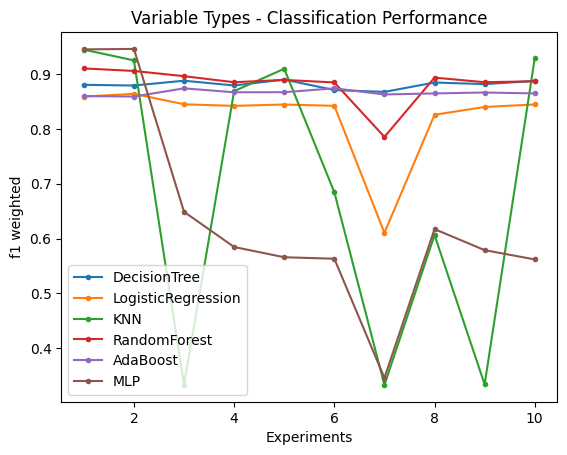

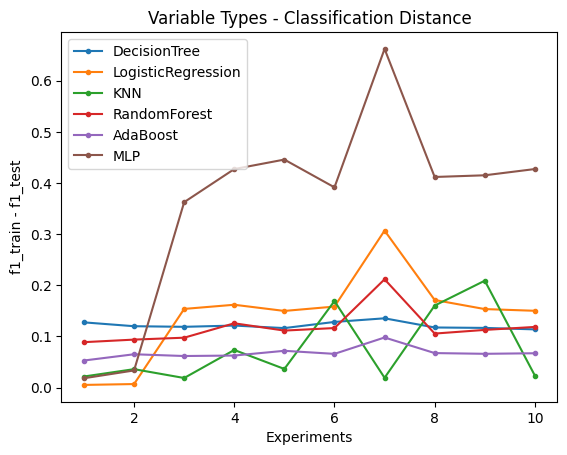

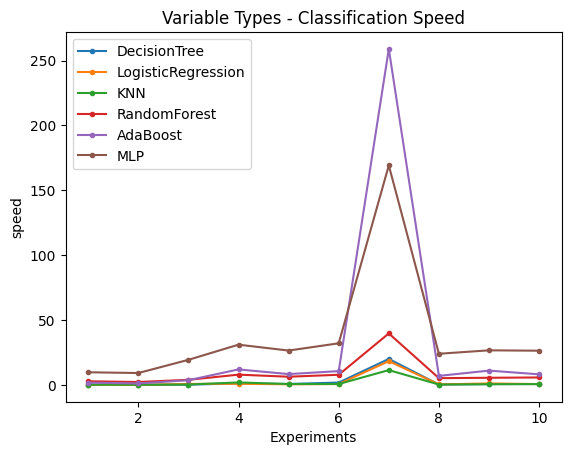

In [ ]:
results_for_each_algorithm = []

for algorithm in CLASSIFICATION_ALGORITHMS: # FIRST CICLE ON THE ALGORITHMS

  results_single_algorithm = []

  # creating the dataset with the labels
  polluted_datasets = zip(X_variable_types_experiments, y_variable_types_experiments)

  for polluted_dataset in polluted_datasets: # SECOND CICLE ON THE POLLUTED DATASETS
    # First, convert to DataFrame to pass it to the categorical encoding function
    df = pd.DataFrame(polluted_dataset[0])
    #df = df.astype({index: 'float' for index in range(INIT_FEATURES)})
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='ignore')
    #print(df, df.shape, df.dtypes)
    df = data_analysis.encoding_categorical_variables(df)
    #print(df, df.shape)
    df.columns = df.columns.astype(str)
    # DATA ANALYSIS
    results_1_analysis = data_analysis.classification(df, polluted_dataset[1].reshape(polluted_dataset[1].shape[0],), algorithm, SEED)
    print(results_1_analysis)
    results_single_algorithm.append(results_1_analysis)

  results_for_each_algorithm.append(results_single_algorithm)

# RESULTS EVALUATION
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Variable Types - Classification Performance", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Variable Types - Classification Distance", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Variable Types - Classification Speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

#Project Pipeline - step \#4: Data Preparation

## Prepared Dataset initialization

In [ ]:
methods = ['linear', 'exp', 'gauss', 'squared']

In [ ]:
X_duplication_experiments_prepared = {key: [] for key in methods}
y_duplication_experiments_prepared = {key: [] for key in methods}

## Data Deduplication

In [ ]:
# data preparation for the duplication experiments
for idx, experiment in enumerate(X_duplication_experiments):

  labels = y_duplication_experiments[idx]

  # indexer initialization and settings
  indexer = recordlinkage.Index()
  indexer.full()

  # from ndarray to dataframe
  df = pd.DataFrame(experiment)

  # candidate links generation
  candidate_links = indexer.index(df)

  print("-" * 100)
  print(" " * 100)
  print("Experiment #" + str(idx+1) + ". Number of rows: " + str(len(experiment)) + ". Number of candidate links: " + str(len(candidate_links)))
  print(" " * 100)

  for method in methods:

    print("METHOD: " + method)
    print(" " * 100)

    # comparison tool initialization and settings
    compare_cl = recordlinkage.Compare()
    for feature_index in range(INIT_FEATURES):
      compare_cl.numeric(feature_index, feature_index, method=method, label=str(feature_index))

    # comparison
    features = compare_cl.compute(candidate_links, df)
    print("Comparison results:")
    print(features)

    print(" " * 100)

    threshold = 4.99
    matches = None
    while(matches is None):
      # non-exact duplicates found
      matches = features[features.sum(axis=1) > threshold]

      if len(matches) == 0:
        threshold -= 0.05
        if threshold < 4.49:
          break
        else:
          matches = None
      else:
        print("Non-exact duplicates:")
        print(matches)

    # discarding the duplicates
    prepared_dataset = experiment.copy()
    duplicate_indices = matches.index.get_level_values(1)
    prepared_dataset = np.array([experiment[i] for i in range(len(experiment)) if i not in duplicate_indices])
    prepared_labels = np.array([labels[i] for i in range(len(experiment)) if i not in duplicate_indices])
    X_duplication_experiments_prepared[method].append(prepared_dataset)
    y_duplication_experiments_prepared[method].append(prepared_labels)

    print(" " * 100)
    print("Duplicates detected: " + str(len(experiment) - len(prepared_dataset)))

    print(" " * 100)
    print("-" * 100)

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #1. Number of rows: 1050. Number of candidate links: 550725
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.643828  0.949583  0.375717  0.000000  0.195883
2    0     0.907838  0.610367  0.006856  0.000000  0.687142
     1     0.551666  0.559950  0.631139  0.923331  0.508741
3    0     0.535033  0.835845  0.029823  0.916150  0.146670
     1     0.178861  0.785429  0.654107  0.000000  0.000000
...             ...       ...       ...       ...       ...
1049 1044  0.704389  0.959778  0.515266  0.733033  0.000000
     1045 

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #2. Number of rows: 1500. Number of candidate links: 1124250
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.562233  0.000000  0.496879  0.000000  0.011658
2    0     0.822131  0.407913  0.000000  0.000000  0.000000
     1     0.384364  0.233970  0.468678  0.802173  0.462537
3    0     0.830283  0.492215  0.000000  0.000000  0.000000
     1     0.731950  0.149667  0.000000  0.937823  0.000000
...             ...       ...       ...       ...       ...
1499 1494  0.699852  0.210239  0.817725  0.000000  0.000000
     1495

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #3. Number of rows: 1050. Number of candidate links: 550725
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.873435  0.827761  0.670448  0.000000  0.252066
2    0     0.000000  0.000000  0.000000  0.000000  0.181483
     1     0.000000  0.000000  0.269543  0.770872  0.929417
3    0     0.000000  0.000000  0.746149  0.298310  0.000000
     1     0.000000  0.000000  0.416597  0.401950  0.000000
...             ...       ...       ...       ...       ...
1049 1044  0.000000  0.000000  0.000000  0.000000  0.429848
     1045 

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #4. Number of rows: 1500. Number of candidate links: 1124250
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.000000  0.000000  0.038142  0.597686  0.668194
2    0     0.903773  0.986690  0.668876  0.823451  0.734070
     1     0.000000  0.000000  0.369266  0.774235  0.402263
3    0     0.639526  0.780889  0.000000  0.762505  0.555650
     1     0.000000  0.000000  0.421424  0.835182  0.223844
...             ...       ...       ...       ...       ...
1499 1494  0.155649  0.022441  0.536296  0.000000  0.000000
     1495

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #5. Number of rows: 1050. Number of candidate links: 550725
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.791919  0.426767  0.501622  0.518484  0.112868
2    0     0.000000  0.352199  0.144177  0.377109  0.927439
     1     0.000000  0.925431  0.000000  0.000000  0.185428
3    0     0.984754  0.226154  0.635426  0.982386  0.959616
     1     0.807165  0.799387  0.137048  0.536098  0.153252
...             ...       ...       ...       ...       ...
1049 1044  0.740887  0.000000  0.117412  0.000000  0.466375
     1045 

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #6. Number of rows: 1500. Number of candidate links: 1124250
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.228836  0.701621  0.039762  0.861425  0.615885
2    0     0.358780  0.000000  0.264126  0.000000  0.074843
     1     0.870056  0.116719  0.775636  0.000000  0.000000
3    0     0.302667  0.363103  0.719473  0.322497  0.000000
     1     0.000000  0.661482  0.320289  0.183922  0.000000
...             ...       ...       ...       ...       ...
1499 1494  0.037030  0.073215  0.000000  0.918703  0.621877
     1495

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #7. Number of rows: 1050. Number of candidate links: 550725
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.636744  0.938282  0.000000  0.000000  0.000000
2    0     0.000000  0.000000  0.000000  0.000000  0.634180
     1     0.265628  0.000000  0.245716  0.539902  0.000000
3    0     0.000000  0.872838  0.481703  0.620859  0.001292
     1     0.000000  0.811120  0.376659  0.000000  0.000000
...             ...       ...       ...       ...       ...
1049 1044  0.921368  0.194752  0.000000  0.716854  0.599174
     1045 

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #8. Number of rows: 1500. Number of candidate links: 1124250
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.688573  0.000000  0.392831  0.219619  0.000000
2    0     0.509084  0.000000  0.385909  0.847172  0.517845
     1     0.820512  0.820461  0.000000  0.372447  0.000000
3    0     0.689454  0.000000  0.940009  0.000000  0.000000
     1     0.999118  0.983074  0.452822  0.287045  0.500486
...             ...       ...       ...       ...       ...
1499 1494  0.798635  0.000000  0.000000  0.164966  0.000000
     1495

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #9. Number of rows: 1050. Number of candidate links: 550725
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.000000  0.067425  0.000000  0.181186  0.000000
2    0     0.000000  0.984673  0.226309  0.000000  0.431151
     1     0.780868  0.052098  0.630387  0.531519  0.000000
3    0     0.000000  0.000000  0.097630  0.705446  0.000000
     1     0.876906  0.341440  0.000000  0.000000  0.000000
...             ...       ...       ...       ...       ...
1049 1044  0.663899  0.759899  0.000000  0.908136  0.000000
     1045 

----------------------------------------------------------------------------------------------------
                                                                                                    
Experiment #10. Number of rows: 1500. Number of candidate links: 1124250
                                                                                                    
METHOD: linear
                                                                                                    
Comparison results:
                  0         1         2         3         4
1    0     0.801952  0.000000  0.652657  0.369298  0.821785
2    0     0.738001  0.241566  0.694550  0.802684  0.000000
     1     0.936048  0.000000  0.347207  0.566615  0.000000
3    0     0.079765  0.672153  0.931133  0.138435  0.000000
     1     0.277812  0.000000  0.583790  0.769137  0.000000
...             ...       ...       ...       ...       ...
1499 1494  0.960250  0.975211  0.000000  0.857985  0.000000
     149

# Project Pipeline - step \#5: Data Analysis and Evaluation

In [ ]:
results_for_each_method = []

In [ ]:
for method in methods:

  print("METHOD: " + method)

  results_for_each_algorithm = {algorithm: [] for algorithm in CLASSIFICATION_ALGORITHMS}

  for algorithm in CLASSIFICATION_ALGORITHMS: # FIRST CICLE ON THE ALGORITHMS

    results_single_algorithm = []

    # creating the dataset with the labels
    polluted_datasets = zip(X_duplication_experiments_prepared[method], y_duplication_experiments_prepared[method])

    for polluted_dataset in polluted_datasets: # SECOND CICLE ON THE POLLUTED DATASETS
      # DATA ANALYSIS
      results_1_analysis = data_analysis.classification(polluted_dataset[0], polluted_dataset[1].reshape(polluted_dataset[1].shape[0],), algorithm, SEED)
      print(results_1_analysis)
      results_single_algorithm.append(results_1_analysis)

    results_for_each_algorithm[algorithm] = results_single_algorithm

  # RESULTS EVALUATION
  #plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Duplication - Classification Performance (Cleaned)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
  #plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Duplication - Distance (Cleaned)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
  #plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=results_for_each_algorithm, title="Duplication - Classification Speed (Cleaned)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")
  results_for_each_method.append(results_for_each_algorithm)

METHOD: linear
Training for DecisionTree...
{'mean_perf': 0.870435558459754, 'distance': 0.1275059211046806, 'speed': 0.05527615547180176}
Training for DecisionTree...
{'mean_perf': 0.8903625607354202, 'distance': 0.12539715189883, 'speed': 0.05368661880493164}
Training for DecisionTree...
{'mean_perf': 0.869787360237078, 'distance': 0.11911147521204499, 'speed': 0.05148053169250488}
Training for DecisionTree...
{'mean_perf': 0.901924912327505, 'distance': 0.09973227936567929, 'speed': 0.08546948432922363}
Training for DecisionTree...
{'mean_perf': 0.3201907124526338, 'distance': 0.0420528171246358, 'speed': 0.023352861404418945}
Training for DecisionTree...
{'mean_perf': 0.4087275549978583, 'distance': 0.053238275386558585, 'speed': 0.02927875518798828}
Training for DecisionTree...
{'mean_perf': 0.8710346887080821, 'distance': 0.12740392696546599, 'speed': 0.055564165115356445}
Training for DecisionTree...
{'mean_perf': 0.7848594290014776, 'distance': 0.20097006965587222, 'speed': 0.0

In [ ]:
# Function to calculate average metrics for each experiment for each algorithm
def calculate_averages(dictionaries):
    # Initialize the final dictionary to store averaged metrics
    averaged_dict = {}

    # Get the list of all algorithms
    algorithms = dictionaries[0].keys()

    for algorithm in algorithms:
        averaged_dict[algorithm] = []

        # Iterate over each experiment index
        for i in range(len(dictionaries[0][algorithm])):
            sum_mean_perf = sum_distance = sum_speed = 0

            # Sum up the values for each metric across all dictionaries
            for dic in dictionaries:
                sum_mean_perf += dic[algorithm][i]['mean_perf']
                sum_distance += dic[algorithm][i]['distance']
                sum_speed += dic[algorithm][i]['speed']

            # Calculate averages
            avg_mean_perf = sum_mean_perf / len(dictionaries)
            avg_distance = sum_distance / len(dictionaries)
            avg_speed = sum_speed / len(dictionaries)

            # Store the averages in the list for this algorithm
            averaged_dict[algorithm].append({
                'mean_perf': avg_mean_perf,
                'distance': avg_distance,
                'speed': avg_speed
            })

    return averaged_dict

In [ ]:
dic_final = calculate_averages(results_for_each_method)

In [ ]:
def dict_to_list_of_lists(input_dict):
    # Initialize a list to hold lists of experiment dictionaries
    list_of_lists = []

    # Iterate over each algorithm in the dictionary
    for algorithm in input_dict:
        # Append the list of experiments for this algorithm
        list_of_lists.append(input_dict[algorithm])

    return list_of_lists

In [ ]:
final_performances = dict_to_list_of_lists(dic_final)

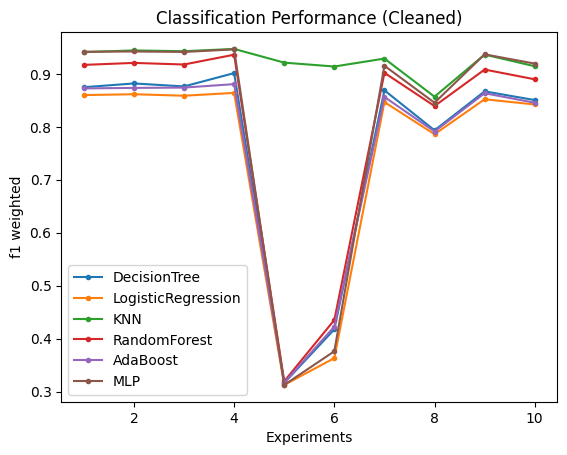

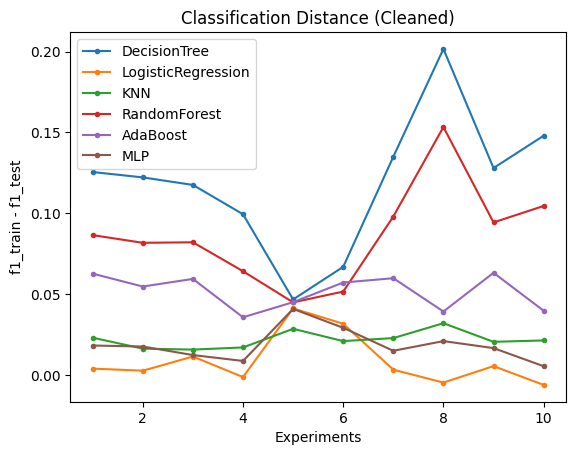

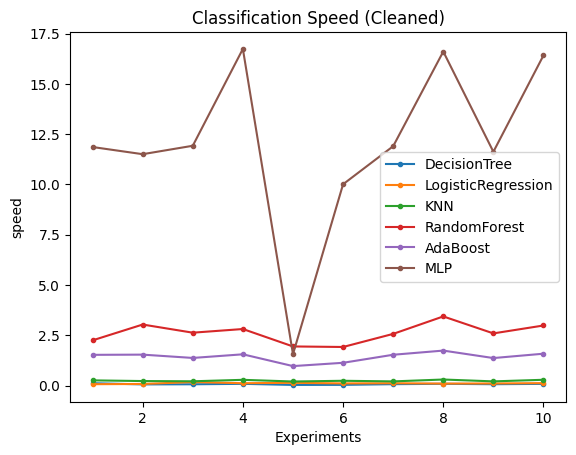

In [ ]:
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=final_performances, title="Classification Performance (Cleaned)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=final_performances, title="Classification Distance (Cleaned)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot_results.plot(x_axis_values=list(range(1,11)), x_label="Experiments", results=final_performances, title="Classification Speed (Cleaned)", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")